In [2]:
import torch
torch.cuda.empty_cache() 

In [3]:
import os 
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import cv2
import urllib.request
from PIL import Image

In [4]:
import pandas as pd
import pyproj

In [5]:
import os 
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [6]:
from pathlib import Path

In [7]:
import joblib

In [8]:
from mt_function_yl import *

In [9]:
import seaborn as sn

### Data loading

In [10]:
# Curb extraction data
preda = pd.read_csv('/home/yelhe/script/mt/output/pred_accident_label.csv')
predp = pd.read_csv('/home/yelhe/script/mt/output/pred_pseudo_label.csv')

In [11]:
nla = pd.read_csv('/home/yelhe/script/mt/output/n_accident.txt', header=None)

In [12]:
nla.rename(columns = {0:'Nr'}, inplace = True)
nla['Nr'] = nla['Nr'].values.astype(str)
nla['id'] = nla['Nr'].str[-15:-1]
nla['dir'] = nla['Nr'].str[-1]

In [13]:
nla1 = nla[['id', 'dir']]

In [14]:
nla2 = nla1
nla3 = nla1
nla4 = nla1
nla2 = nla2.assign(dir = '2')
nla3 = nla3.assign(dir = '3')
nla4 = nla4.assign(dir = '4')

In [15]:
nlas = pd.concat([nla1, nla2, nla3, nla4])

In [16]:
nlas['Nr'] = nlas['id'] + nlas['dir']

In [17]:
nlas0 = nlas
nlas1 = nlas
nlas2 = nlas
nlas3 = nlas
nlas0 = nlas0.assign(p = '0')
nlas1 = nlas1.assign(p = '1')
nlas2 = nlas2.assign(p = '2')
nlas3 = nlas3.assign(p = '3')

In [18]:
nlass = pd.concat([nlas0, nlas1, nlas2, nlas3])

In [19]:
nlass

,id,dir,Nr,p
0,99900060852597,1,999000608525971,0
1,99900063018611,1,999000630186111,0
2,99900052723510,1,999000527235101,0
3,99900061514043,1,999000615140431,0
4,99900063037843,1,999000630378431,0
...,...,...,...,...
290,99900056387598,4,999000563875984,3
291,99900055999694,4,999000559996944,3
292,99900055905276,4,999000559052764,3
293,99900060670975,4,999000606709754,3


In [21]:
preda = preda[['Nr', 'p']]

In [22]:
preda = preda.groupby(['Nr', 'p']).size().reset_index().rename(columns={0:'count'})


In [23]:
preda['p'] = preda['p'].values.astype(str)

In [24]:
preda['Nr'] = preda['Nr'].values.astype(str)
preda['id'] = preda['Nr'].str[-15:-1]
preda['dir'] = preda['Nr'].str[-1]

In [25]:
pa = nlass.merge(preda, how = 'left', on = ['id', 'Nr', 'dir', 'p'])

In [26]:
pa = pa.sort_values(by = ['id', 'dir', 'p'], ignore_index = True)

In [27]:
pa = pa.fillna(0)

In [28]:
# pa.to_csv('/home/yelhe/script/mt/output/predlabel_accident_count.csv', index = False)

In [29]:
pa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4720 entries, 0 to 4719
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      4720 non-null   object 
 1   dir     4720 non-null   object 
 2   Nr      4720 non-null   object 
 3   p       4720 non-null   object 
 4   count   4720 non-null   float64
dtypes: float64(1), object(4)
memory usage: 184.5+ KB


In [30]:
pac = pa.loc[pa['p'] == '0']

In [31]:
pacc = pac.groupby(['id'])['count'].sum().reset_index().rename(columns = {'count':'sum'})

In [32]:
# pacc.to_csv('/home/yelhe/script/mt/output/predcurb_accident_count_sum.csv', index = False)

(array([145.,  86.,  34.,  16.,   7.,   2.,   1.,   2.,   1.,   1.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

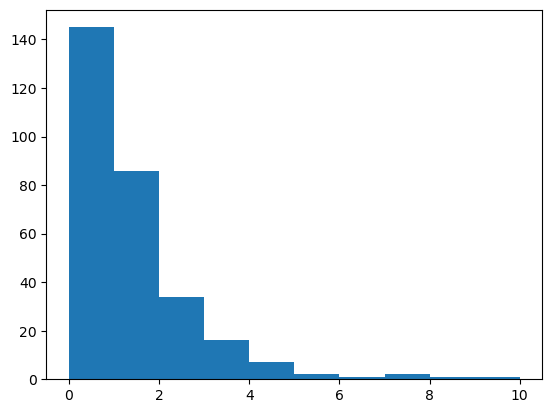

In [33]:
plt.hist(pacc['sum'])

(array([963.,   0., 168.,   0.,  40.,   0.,   7.,   0.,   1.,   1.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

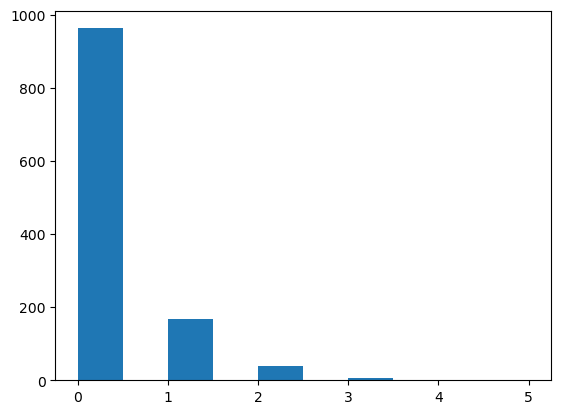

In [34]:
plt.hist(pac['count'])

In [35]:
# Consider four directions in each location
paccd = pac.groupby(['id', 'dir'])['count'].sum().reset_index()

In [37]:
pacm = paccd.groupby('id', as_index = True)[['count']].mean()
pacm.rename(columns ={'count':'cmean'}, inplace = True)
pacm = pacm.reset_index()

In [38]:
pacmin = paccd.groupby('id', as_index = True)[['count']].min()
pacmin.rename(columns = {'count':'cmin'}, inplace = True)
pacmin = pacmin.reset_index()

In [39]:
pacmax = paccd.groupby('id', as_index = True)[['count']].max()
pacmax.rename(columns = {'count':'cmax'}, inplace = True)
pacmax = pacmax.reset_index()

In [40]:
pac1 = pd.merge(pacm, pacmin, on = ['id'])
pac2 = pd.merge(pacc, pacmax, on = ['id'])
pac_all = pd.merge(pac1, pac2, on = ['id'])

In [42]:
pac_all.rename(columns = {'sum': 'csum'}, inplace = True)
# pac_all.to_csv('/home/yelhe/script/mt/output/accident_predictedcurball.csv', index = False)

#### For pseudo

In [43]:
predp = predp[['Nr', 'p']]

In [44]:
nlp = pd.read_csv('/home/yelhe/script/mt/output/n_pseudo.txt', header = None)

In [45]:
nlp.rename(columns = {0:'Nr'}, inplace = True)
nlp['Nr'] = nlp['Nr'].values.astype(str)
nlp['Nr'] = nlp['Nr'].str.zfill(5)
nlp['id'] = nlp['Nr'].str[-5:-1]
nlp['dir'] = nlp['Nr'].str[-1]

In [46]:
nlp1 = nlp[['id','dir']]
nlp2= nlp1
nlp3= nlp1
nlp4= nlp1
nlp2 = nlp2.assign(dir = '2')
nlp3 = nlp3.assign(dir = '3')
nlp4 = nlp4.assign(dir = '4')

In [47]:
nlps = pd.concat([nlp1, nlp2, nlp3, nlp4])

In [48]:
nlps['Nr'] = nlps['id'] + nlps['dir']

In [49]:
nlps0 = nlps
nlps1 = nlps
nlps2 = nlps
nlps3 = nlps
nlps0 = nlps0.assign(p = '0')
nlps1 = nlps1.assign(p = '1')
nlps2 = nlps2.assign(p = '2')
nlps3 = nlps3.assign(p = '3')
nlpss = pd.concat([nlps0, nlps1, nlps2, nlps3])

In [50]:
predp = predp.groupby(['Nr','p']).size().reset_index().rename(columns={0:'count'})
predp['p'] = predp['p'].values.astype(str)
predp['Nr'] = predp['Nr'].values.astype(str)
predp['Nr'] = predp['Nr'].str.zfill(5)
predp['id'] = predp['Nr'].str[-5:-1]
predp['dir'] = predp['Nr'].str[-1]

In [51]:
pp = nlpss.merge(predp, how = 'left', on = ['id', 'Nr', 'dir', 'p'])

In [52]:
pp = pp.sort_values(by = ['id', 'dir', 'p'], ignore_index = True)
pp = pp.fillna(0)

In [215]:
# pp.to_csv('/home/yelhe/script/mt/output/predlabel_pseudo_count.csv', index = False)

In [53]:
pp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12672 entries, 0 to 12671
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      12672 non-null  object 
 1   dir     12672 non-null  object 
 2   Nr      12672 non-null  object 
 3   p       12672 non-null  object 
 4   count   12672 non-null  float64
dtypes: float64(1), object(4)
memory usage: 495.1+ KB


In [54]:
ppc = pp.loc[pp['p'] == '0']

In [55]:
ppc

,id,dir,Nr,p,count
0,0002,1,00021,0,0.0
4,0002,2,00022,0,0.0
8,0002,3,00023,0,1.0
12,0002,4,00024,0,0.0
16,0003,1,00031,0,0.0
...,...,...,...,...,...
12652,0993,4,09934,0,0.0
12656,0994,1,09941,0,0.0
12660,0994,2,09942,0,0.0
12664,0994,3,09943,0,0.0
